# CONSIGNA

Aprendizaje Profundo  
Trabajo Práctico Evaluativo N 1 - Constancio Malena  
Objetivo:  
Desarrollar un modelo de clasificación de dígitos manuscritos utilizando el conjunto de datos MNIST y permitir que los alumnos prueben el modelo con imágenes de dígitos creadas por ellos mismos.  
Descripción:  
1.	Entrenar un modelo de red neuronal en el conjunto de datos MNIST.  
2.	Preprocesar imágenes nuevas creadas por los alumnos. Para este apartado los alumnos deberán crear un dataset de 3 a 5 imágenes propias de dígitos manuscritos los cuales utilizaran para predecir con el modelo entrenado.  
3.	Deben mostrar cada predicción y el porcentaje de acierto para cada imagen.  
  
Pasos Sugeridos:
1. Importar Librerías y Cargar el Conjunto de Datos MNIST
2. Preprocesamiento de Datos
3. Construcción y Entrenamiento del Modelo
4. Evaluación del Modelo
5. Preprocesamiento de Imágenes Nuevas
6. Predicción con el Modelo Entrenado

# IMPORTS

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import viridis
import seaborn as sns
from PIL import Image

from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout,InputLayer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
#from skimage import transform, filters
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report,confusion_matrix
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV, KFold

# CLASES AUXILIARES

In [2]:
class EDA_Imagen:

    def __init__(self):
        pass

    def tamanios(self,lista):
      tamanio = []
      alto_total = 0
      ancho_total = 0
      for i, imagen in enumerate(lista):
        if i < 10:
         tamanio.append(imagen.shape[:2])
      print(f'El tamaño de las primeras 10 imagenes es:{tamanio}')

      for alto, ancho in tamanio:
        i+=1
        alto_total = alto + alto_total
        ancho_total = ancho + ancho_total
      alto_total = alto_total // i
      ancho_total = ancho_total // i
      print(f'El tamaño promedio de las imagenes es: alto:{alto_total}, ancho:{ancho_total}')

    def escalado (self,lista_imagenes, alto, ancho,interpolado):
      if interpolado == 1:
          inter = cv2.INTER_AREA
      elif interpolado == 2:
          inter = cv2.INTER_CUBIC
      else:
          inter = cv2.INTER_LINEAR

      dimensionada = []

      for imagen in lista_imagenes:
          dimensionada.append(cv2.resize(imagen,(alto,ancho),interpolation=inter))
      return dimensionada


    def ecualizador(self,lista,color):
      ecualizado = []

      if color == 1:
        for imagen_color in lista:
          canal_b, canal_g, canal_r = cv2.split(imagen_color)
          canal_b_ecualizado = cv2.equalizeHist(canal_b)
          canal_g_ecualizado = cv2.equalizeHist(canal_g)
          canal_r_ecualizado = cv2.equalizeHist(canal_r)
          ecualizado.append( cv2.merge((canal_b_ecualizado, canal_g_ecualizado, canal_r_ecualizado)))
      else:
        for imagen_gris in lista:
          ecualizado.append(cv2.equalizeHist(imagen_gris))

      return ecualizado

    def nom_brillo(self,lista, color):
      brillo_normalizado = []

      if color == 1:
        brillos = []
        for imagen in lista:
            brillo_promedio = sum(cv2.mean(imagen)[:3]) / 3
            brillos.append(brillo_promedio)
        mean_valor = (max(brillos) / min(brillos))

        for imagen in lista:
          brillo_normalizado.append(cv2.convertScaleAbs(imagen, alpha=mean_valor, beta=0))

      else:
        brillos = []
        for imagen in lista:
          brillos.append(cv2.mean(imagen)[0])
          suma_valores = sum(brillos)
          cant_valores = len(brillos)
          mean_valor = suma_valores / cant_valores

          for imagen in lista:
            brillo_normalizado.append(cv2.convertScaleAbs(imagen, alpha=mean_valor, beta=0))

      return brillo_normalizado

    def contraste_normal(self, lista, color, factor_contraste):

      contraste_normalizado = []

      if color == 1:
        for imagen_tratar in lista:
          contraste_normalizado.append(cv2.convertScaleAbs(imagen_tratar, alpha=factor_contraste, beta=0))

      else:
        for imagen_tratar in lista:
          imagen_ajustada = np.clip(imagen_tratar * factor_contraste, 0, 255).astype(np.uint8)
          contraste_normalizado.append(imagen_ajustada)

      return contraste_normalizado

    def saturacion_normal(self, lista, factor_saturacion):

      saturacion_normalizado = []
      for imagen_tratar in lista:
            imagen_hsv = cv2.cvtColor(imagen_tratar, cv2.COLOR_BGR2HSV)
            h, s, v = cv2.split(imagen_hsv)
            s_new = np.clip(s * factor_saturacion, 0, 255).astype(np.uint8)
            imagen_saturada = cv2.merge((h, s_new, v))
            imagen_saturada_rgb = cv2.cvtColor(imagen_saturada, cv2.COLOR_HSV2RGB)
            imagen_saturada_rgb = cv2.cvtColor(imagen_saturada_rgb, cv2.COLOR_BGR2RGB)
            saturacion_normalizado.append(imagen_saturada_rgb)

      return saturacion_normalizado

    def aliasing_normal(self,lista, factor_aumento, sigma, color):
        aliasin_normal = []
        for imagen in lista:
            superresized_image = transform.rescale(imagen, factor_aumento, anti_aliasing=True)
            smoothed_image = filters.gaussian(superresized_image, sigma=sigma)
            reduced_aliasing_image = transform.rescale(smoothed_image, 1/factor_aumento, anti_aliasing=True)

            if color == 1:
               imagen64f_normalizada = cv2.normalize(reduced_aliasing_image, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_64F)
               escalada = cv2.convertScaleAbs(imagen64f_normalizada, alpha=(255.0/1.0))
               aliasin_normal.append(cv2.cvtColor(escalada, cv2.COLOR_RGB2BGR))
            else:
               aliasin_normal.append(reduced_aliasing_image)

        return aliasin_normal

    def histogramas (self,lista_imagenes, cant_imagenes):
      if len(lista_imagenes) > 2:
        imagenes_gris = []
        for imagen in lista_imagenes:
          imagenes_gris.append( cv2.cvtColor(imagen, cv2.COLOR_BGR2GRAY))
      else:
        imagenes_gris  = lista_imagenes

      histogramas = []
      for imagen in imagenes_gris:
        histogramas.append(cv2.calcHist([imagen], [0], None, [256], [0, 256]))

      fig, axes = plt.subplots(1, cant_imagenes, figsize=(12, 3))
      for i in range(cant_imagenes):
            if i < len(histogramas):
                hist = histogramas[i]
                axes[i].hist(hist, color='red',bins=1024 ,edgecolor='black', linewidth=0.3)
                axes[i].set_xlim(0, 50)
                axes[i].set_ylim(0, 50)
            else:
                axes[i].axis('off')
      fig.tight_layout()

      plt.show()

    def visualizar(self,lista_imagenes):
      num_images = len(lista_imagenes)
      num_rows = (num_images + 3) // 4

      fig, axes = plt.subplots(num_rows, 4, figsize=(10, 10))

      for i, ax in enumerate(axes.flat):
          if i < num_images:
              ax.imshow(cv2.cvtColor(lista_imagenes[i], cv2.COLOR_BGR2RGB))
              ax.axis('off')
          else:
              ax.axis('off')

      plt.show()

    def normalizar_imagenes(self, lista_imagenes):
        return [imagen.astype('float32') / 255.0 for imagen in lista_imagenes]

    def invertir_colores(self, lista):
        invertidas = []
        for imagen in lista:
            invertidas.append(255 - imagen)

        return invertidas

    def deteccion_bordes(self, lista, threshold1=100, threshold2=200):
        bordes = []
        for imagen in lista:
            imagen_uint8 = cv2.convertScaleAbs(imagen)
            bordes.append(cv2.Canny(imagen, threshold1, threshold2))

        return bordes

    def cargar_imagen(self, img_path, color_mode='grayscale'):
        img = load_img(img_path, color_mode=color_mode, target_size=(28, 28))
        img_array = img_to_array(img)

        return img_array

    def preprocesar_imagen_mnist(self, img_path):
        img = self.cargar_imagen(img_path)
        img = self.invertir_colores([img])[0]
        img = img.astype('float32') / 255.0
        img = np.reshape(img, (28, 28,1))

        return img

    def plot_class_distribution(self, labels, title):
        unique, counts = np.unique(labels, return_counts=True)
        colors = viridis(np.linspace(0, 1, len(unique)))
        plt.bar(unique, counts, tick_label=unique, color=colors)
        plt.title(title)
        plt.xlabel('Clase')
        plt.ylabel('Frecuencia')

        for i, count in enumerate(counts):
            plt.text(unique[i], count, str(count), ha='center', va='bottom')

        plt.show()

    def display_images(self,images, labels, title):
        plt.figure(figsize=(10, 5))
        for i in range(len(images)):
            img = Image.fromarray(images[i])
            plt.subplot(2, 5, i + 1)
            plt.imshow(img, cmap='gray')
            plt.title(f'Label: {labels[i]}')
            plt.axis('off')
        plt.suptitle(title)
        plt.show()

# OBTENCIÓN DEL DATASET Y PREPROCESAMIENTO

In [3]:
eda_imagen = EDA_Imagen()

MNIST proporciona tanto datos de entrenamiento como de prueba en conjuntos separados. Los datos de entrenamiento consisten en 60,000 imágenes de dígitos escritos a mano, mientras que los datos de prueba consisten en 10,000 imágenes adicionales. Se obtienen dos tuplas: una para los datos de entrenamiento y otra para los datos de prueba. Cada una de estas tuplas contiene dos arrays: uno para las imágenes y otro para las etiquetas correspondientes.

In [4]:
(x_train_raw, y_train), (x_test_raw, y_test) = mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


In [5]:
print("Forma de x_train:", x_train_raw.shape)
print("Forma de y_train:", y_train.shape)
print("Forma de x_test:", x_test_raw.shape)
print("Forma de y_test:", y_test.shape)

Forma de x_train: (60000, 28, 28)
Forma de y_train: (60000,)
Forma de x_test: (10000, 28, 28)
Forma de y_test: (10000,)


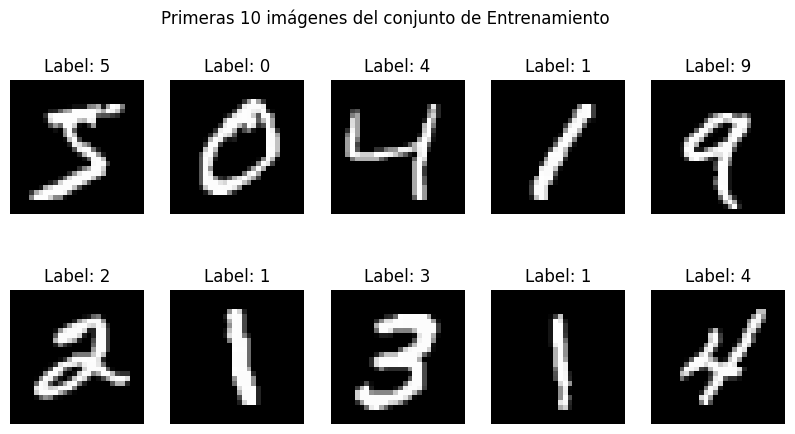

In [6]:
eda_imagen.display_images(x_train_raw[:10], y_train[:10], 'Primeras 10 imágenes del conjunto de Entrenamiento')

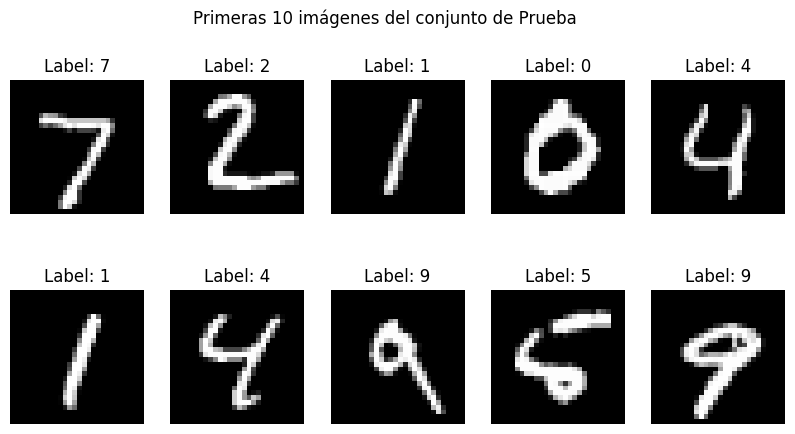

In [7]:
eda_imagen.display_images(x_test_raw[:10], y_test[:10], 'Primeras 10 imágenes del conjunto de Prueba')

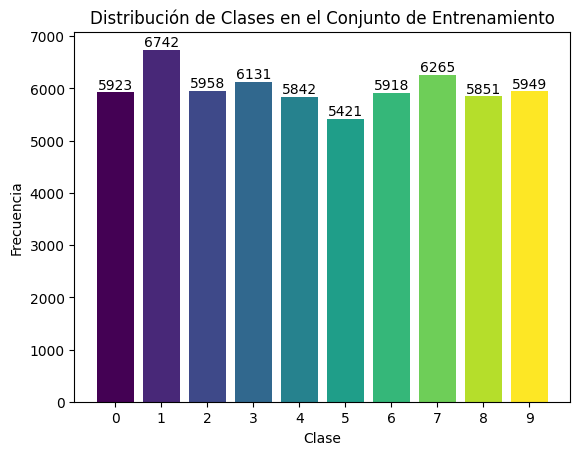

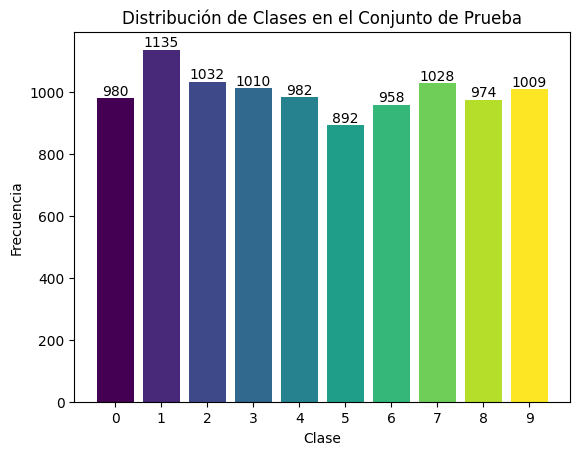

In [8]:
eda_imagen.plot_class_distribution(y_train, 'Distribución de Clases en el Conjunto de Entrenamiento')
eda_imagen.plot_class_distribution(y_test, 'Distribución de Clases en el Conjunto de Prueba')

In [9]:
eda_imagen.tamanios(x_train_raw)

El tamaño de las primeras 10 imagenes es:[(28, 28), (28, 28), (28, 28), (28, 28), (28, 28), (28, 28), (28, 28), (28, 28), (28, 28), (28, 28)]
El tamaño promedio de las imagenes es: alto:0, ancho:0


In [10]:
eda_imagen.tamanios(x_test_raw)

El tamaño de las primeras 10 imagenes es:[(28, 28), (28, 28), (28, 28), (28, 28), (28, 28), (28, 28), (28, 28), (28, 28), (28, 28), (28, 28)]
El tamaño promedio de las imagenes es: alto:0, ancho:0


In [11]:
x_train_preprocessed = eda_imagen.contraste_normal(x_train_raw,0,1.5)
x_test_preprocessed = eda_imagen.contraste_normal(x_test_raw,0,1.5)

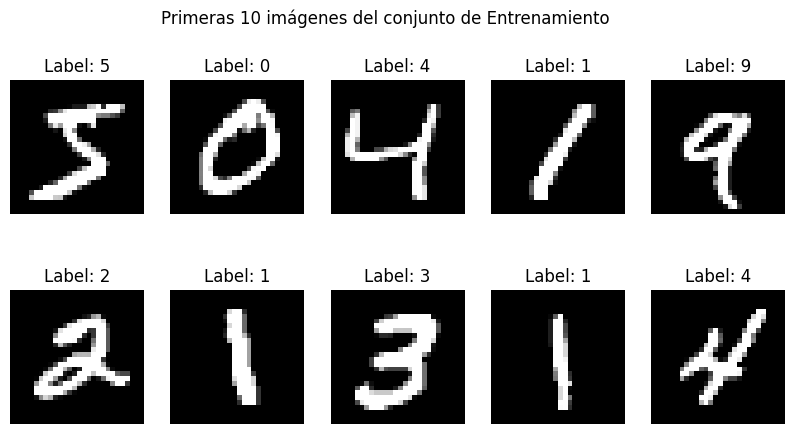

In [12]:
eda_imagen.display_images(x_train_preprocessed[:10], y_train[:10], 'Primeras 10 imágenes del conjunto de Entrenamiento')

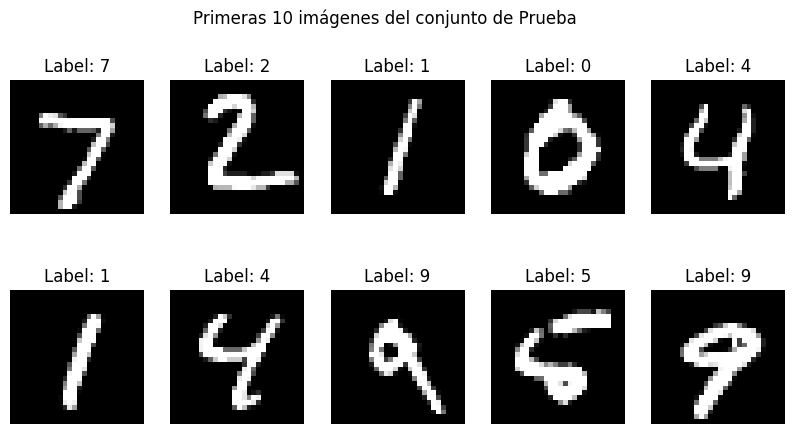

In [13]:
eda_imagen.display_images(x_test_preprocessed[:10], y_test[:10], 'Primeras 10 imágenes del conjunto de Prueba')

In [14]:
#Normalizo las imagenes y las etiquetas:
x_train_normalized = eda_imagen.normalizar_imagenes(x_train_preprocessed)
y_train_encoded = to_categorical(y_train, 10)

x_test_normalized = eda_imagen.normalizar_imagenes(x_test_preprocessed)
y_test_encoded = to_categorical(y_test, 10)

# CONSTRUCCIÓN Y ENTRENAMIENTO DEL MODELO

###Breve explicación del código desarrollado debajo:   
Expando una dimensión porque la capa de entrada requiere que le pase los canales ademas de las imagenes , el alto y el ancho.  
Despues defino el modelo que recibirá dos parámetros el learning rate y el dropout rate , esto lo hago para poder luego utilizar grid search y obtener la mejor combinación de parámetros, entonces cada vez que cree el modelo podré pasarle estos parámetros.  
El modelo consta de 1 capa de entrada donde defino la forma que tendrán los datos que recibe , 2 capas convolucionales con un kernel de 3x3 ambas las cuales estan seguidas de una capa max pooling para extraer las caracteristicas y una capa dropout para evitar el sobreajuste por último se utiliza una capa flatten para poder aplanar el vector una capa densa seguida de dropout y la capa de salida densa con activación softmax con 10 neuronas ya que son 10 clases posibles las esperadas y esta cada me devolverá la probabilidad de predicción correspondiente a cada una.  
Por último defino utilizar 3 callbacks EarlyStopping que previene el sobreentrenamiento al detenerlo antes de que comience a disminuir el rendimiento del modelo, ReduceLROnPlateau que ayuda a ajustar la tasa de aprendizaje para mejorar la convergencia y escapar de mínimos locales y ModelCheckpoint que permite guardar el mejor modelo basado en la métrica monitoreada para su uso posterior o para recuperación en caso de interrupciones todos serán basados en la función de perdida de la validación.   
Además decido implemetar la técnica de validación cruzada segmentando en 3 la misma para obtener un modelo mas robusto.


In [15]:
x_train_normalized = np.expand_dims(x_train_normalized, axis=-1)
x_test_normalized = np.expand_dims(x_test_normalized, axis=-1)

In [16]:
def preprocess_data(x):
    x = x.astype('float32') / 255.0
    return np.expand_dims(x, axis=-1)

In [18]:
def create_model(learning_rate=0.001, dropout_rate=0.5):
    model = Sequential([
        InputLayer(input_shape=(28, 28, 1)),
        Conv2D(32, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Dropout(dropout_rate),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Dropout(dropout_rate),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(dropout_rate),
        Dense(10, activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [19]:
model =  KerasClassifier(build_fn=create_model, verbose=1, validation_split=0.1)

<ipython-input-19-966d534a57b5>:2: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model =  KerasClassifier(build_fn=create_model, verbose=1, validation_split=0.1)


In [20]:
param_grid = {
    'batch_size': [8, 16],
    'epochs': [5, 20],
    'learning_rate': [0.001],
    'dropout_rate': [0.2, 0.3]
}

In [21]:
kfold = KFold(n_splits=3, shuffle=True, random_state=42)

In [22]:
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=kfold, n_jobs=1, verbose=3)

In [23]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=0.00001)
]

In [24]:
grid_result = grid.fit(x_train_normalized, y_train_encoded, callbacks=callbacks)
print(f"Mejores métricas: {grid_result.best_score_} usando {grid_result.best_params_}")

Fitting 3 folds for each of 8 candidates, totalling 24 fits
Epoch 1/5
4500/4500 [==============================] - 45s 10ms/step - loss: 0.1936 - accuracy: 0.9387 - val_loss: 0.0497 - val_accuracy: 0.9847 - lr: 0.0010
Epoch 2/5
4500/4500 [==============================] - 47s 10ms/step - loss: 0.0761 - accuracy: 0.9772 - val_loss: 0.0485 - val_accuracy: 0.9865 - lr: 0.0010
Epoch 3/5
4500/4500 [==============================] - 46s 10ms/step - loss: 0.0575 - accuracy: 0.9822 - val_loss: 0.0438 - val_accuracy: 0.9877 - lr: 0.0010
Epoch 4/5
4500/4500 [==============================] - 48s 11ms/step - loss: 0.0473 - accuracy: 0.9851 - val_loss: 0.0372 - val_accuracy: 0.9908 - lr: 0.0010
Epoch 5/5
2500/2500 [==============================] - 9s 3ms/step - loss: 0.0391 - accuracy: 0.9882
[CV 1/3] END batch_size=8, dropout_rate=0.2, epochs=5, learning_rate=0.001;, score=0.988 total time= 4.5min
Epoch 1/5
4500/4500 [==============================] - 46s 10ms/step - loss: 0.1815 - accuracy: 0.9

# EVALUACIÓN DEL MODELO

In [25]:
x_test_normalized = eda_imagen.normalizar_imagenes(x_test_preprocessed)

In [26]:
x_test_normalized = np.expand_dims(x_test_normalized, axis=-1)

In [27]:
x_test_normalized.shape

(10000, 28, 28, 1)

In [28]:
best_model = grid_result.best_estimator_.model
test_loss, test_acc = best_model.evaluate(x_test_normalized, y_test_encoded)
print(f"Test accuracy: {test_acc}")

313/313 [==============================] - 2s 7ms/step - loss: 0.0241 - accuracy: 0.9922
Test accuracy: 0.9922000169754028


In [29]:
y_pred = best_model.predict(x_test_normalized)
y_pred_classes = np.argmax(y_pred, axis=1) # Calcula las etiquetas predichas (la clase con la probabilidad más alta)

Reporte:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       980
           1       1.00      1.00      1.00      1135
           2       0.99      1.00      0.99      1032
           3       1.00      0.99      0.99      1010
           4       0.98      1.00      0.99       982
           5       0.99      0.99      0.99       892
           6       1.00      0.99      0.99       958
           7       0.99      0.99      0.99      1028
           8       0.99      0.99      0.99       974
           9       0.99      0.99      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



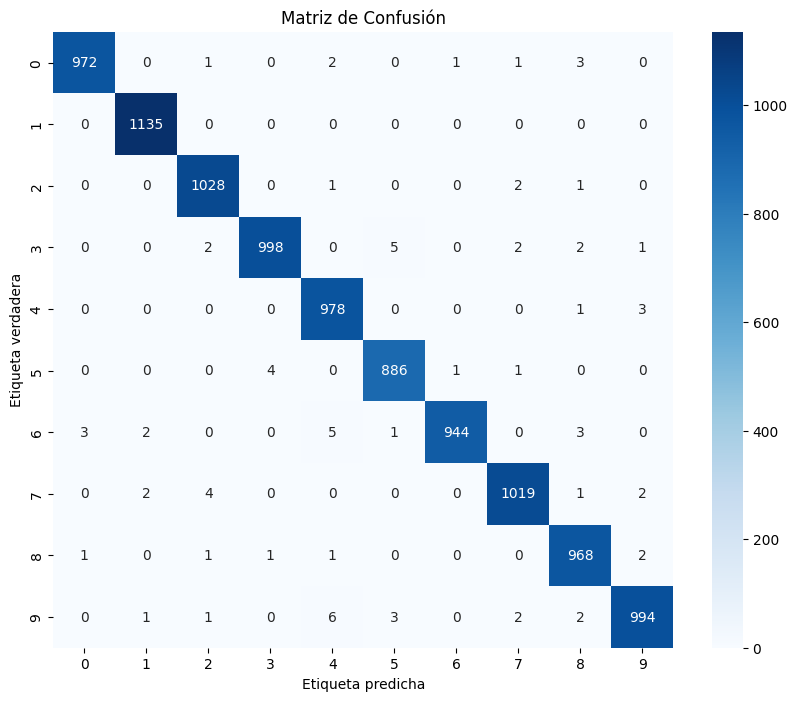

In [30]:
print("Reporte:")
print(classification_report(y_test, y_pred_classes))

conf_matrix = confusion_matrix(y_test, y_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Etiqueta predicha')
plt.ylabel('Etiqueta verdadera')
plt.title('Matriz de Confusión')
plt.show()

# PREPROCESAMIENTO DE IMÁGENES NUEVAS

In [34]:
from google.colab import files
uploaded = files.upload()

Saving 0.jpeg to 0.jpeg
Saving 1.jpeg to 1.jpeg
Saving 5.jpeg to 5.jpeg
Saving 6.jpeg to 6.jpeg
Saving 7.jpeg to 7.jpeg
Saving 8.jpeg to 8.jpeg
Saving 9.jpeg to 9.jpeg
Saving cero.jpeg to cero.jpeg
Saving cinco.jpeg to cinco.jpeg
Saving dos.jpeg to dos.jpeg
Saving four.jpeg to four.jpeg
Saving ii.jpeg to ii.jpeg
Saving iii.jpeg to iii.jpeg
Saving iiii.jpeg to iiii.jpeg
Saving ocho.jpeg to ocho.jpeg
Saving three.jpeg to three.jpeg
Saving tres.jpeg to tres.jpeg
Saving tri.jpeg to tri.jpeg


In [39]:
folder_path = '/content/nums'

if not os.path.exists(folder_path):
    print("Carpeta no encontrada:", folder_path)
else:
    image_files = os.listdir(folder_path)
    print("Archivos en la carpeta:", image_files)

Archivos en la carpeta: ['7.jpeg', 'four.jpeg', 'ii.jpeg', '0.jpeg', 'three.jpeg', '5.jpeg', '6.jpeg', '9.jpeg', 'dos.jpeg', 'cinco.jpeg', 'tri.jpeg', 'ocho.jpeg', '1.jpeg', 'iii.jpeg', 'cero.jpeg', '8.jpeg', 'tres.jpeg', 'iiii.jpeg']


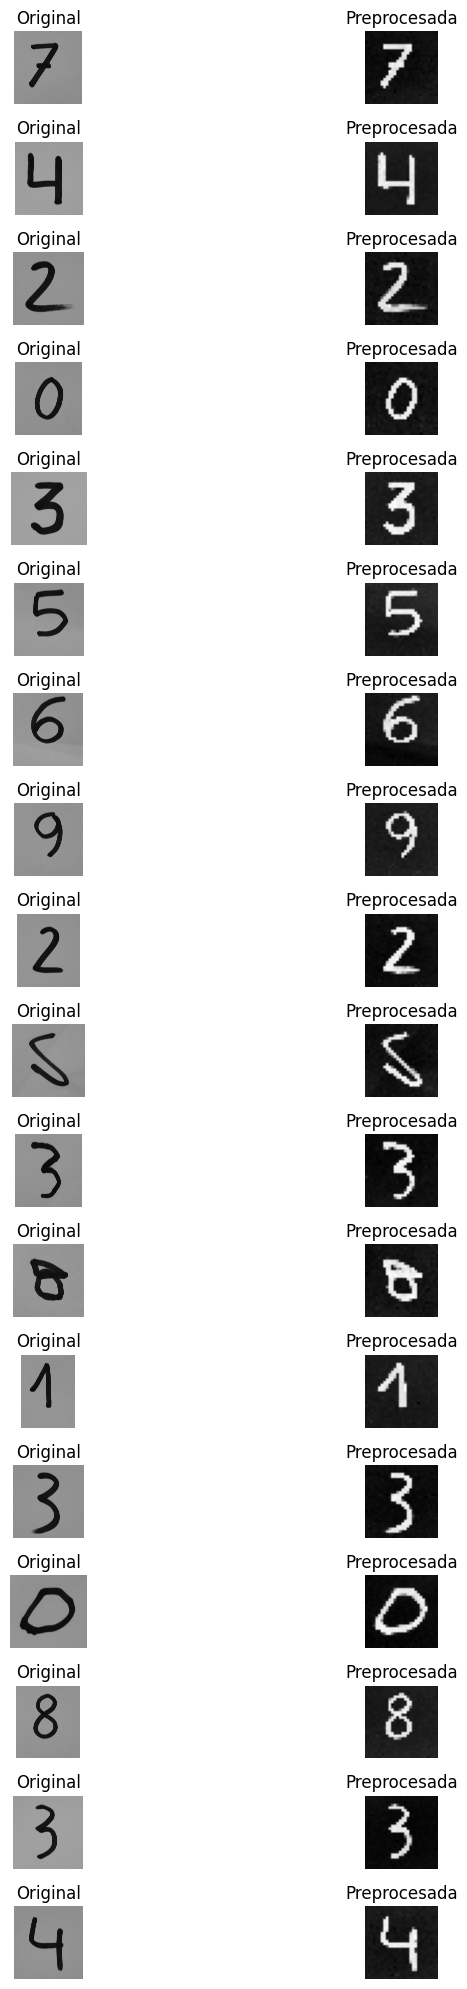

In [40]:
# Lista para almacenar las representaciones preprocesadas de las imágenes
preprocessed_images = []

# Preprocesar las imágenes y almacenarlas en la lista
for img_filename in image_files:
    img_path = os.path.join(folder_path, img_filename)  # Obtener la ruta completa de la imagen
    preprocessed_img = eda_imagen.preprocesar_imagen_mnist(img_path)  # Preprocesar la imagen
    preprocessed_images.append(preprocessed_img)

# Mostrar las imágenes antes y después del preprocesamiento
fig, axes = plt.subplots(nrows=len(image_files), ncols=2, figsize=(10, 20))

for i, (img_filename, img_prep) in enumerate(zip(image_files, preprocessed_images)):
    # Mostrar la imagen original
    img_original = cv2.imread(os.path.join(folder_path, img_filename), cv2.IMREAD_GRAYSCALE)  # Leer la imagen original
    axes[i, 0].imshow(cv2.cvtColor(img_original, cv2.COLOR_BGR2RGB))
    axes[i, 0].set_title('Original')
    axes[i, 0].axis('off')

    # Mostrar la imagen preprocesada
    axes[i, 1].imshow(np.squeeze(img_prep), cmap='gray')
    axes[i, 1].set_title('Preprocesada')
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()

In [41]:
eda_imagen.tamanios(preprocessed_images)

El tamaño de las primeras 10 imagenes es:[(28, 28), (28, 28), (28, 28), (28, 28), (28, 28), (28, 28), (28, 28), (28, 28), (28, 28), (28, 28)]
El tamaño promedio de las imagenes es: alto:10, ancho:10


In [42]:
preprocessed_images_contraste = eda_imagen.contraste_normal(preprocessed_images,0,1.5)

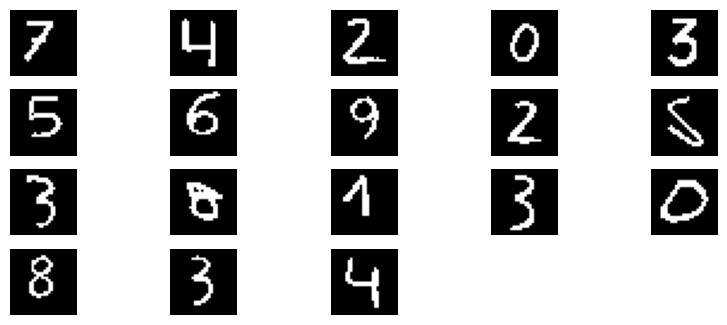

In [43]:
plt.figure(figsize=(10, 5))
for i in range(18):
    plt.subplot(5, 5, i + 1)
    plt.imshow(np.squeeze(preprocessed_images_contraste[i]), cmap='gray')
    plt.axis('off')
plt.show()

In [44]:
preprocessed_images_normalized = eda_imagen.normalizar_imagenes(preprocessed_images_contraste)

In [45]:
preprocessed_images_normalized[0].shape

(28, 28, 1)

In [46]:
true_labels = [7,4,2,0,3,5,6,9,2,5,3,8,1,3,0,8,3,4]

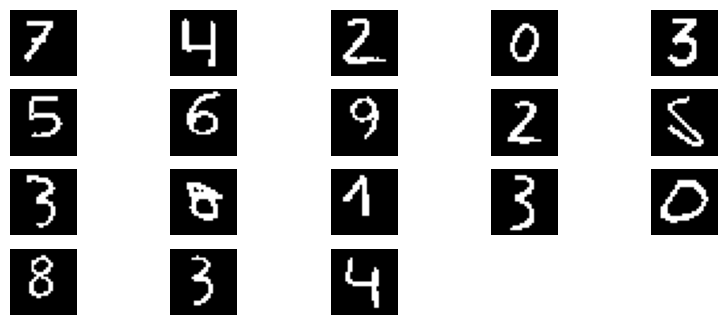

In [47]:
plt.figure(figsize=(10, 5))
for i in range(18):
    plt.subplot(5, 5, i + 1)
    plt.imshow(np.squeeze(preprocessed_images_normalized[i]), cmap='gray')
    plt.axis('off')
plt.show()

# PREDICCIÓN CON EL MODELO ENTRENADO

In [56]:
model_check = load_model('best_model.h5')

In [58]:
# Convertir la lista a un array numpy
preprocessed_images = np.array(preprocessed_images)
preprocessed_images = preprocessed_images.reshape(len(preprocessed_images), 28, 28, 1)

In [59]:
predictions_ch = model_check.predict(preprocessed_images)
predicted_classes_ck = np.argmax(predictions_ch, axis=1)
confidence_scores = np.max(predictions_ch, axis=1) * 100

Reporte:
              precision    recall  f1-score   support

           0       0.50      1.00      0.67         2
           1       1.00      1.00      1.00         1
           2       1.00      1.00      1.00         2
           3       1.00      1.00      1.00         4
           4       1.00      1.00      1.00         2
           5       1.00      1.00      1.00         2
           6       0.00      0.00      0.00         1
           7       1.00      1.00      1.00         1
           8       1.00      0.50      0.67         2
           9       1.00      1.00      1.00         1

    accuracy                           0.89        18
   macro avg       0.85      0.85      0.83        18
weighted avg       0.89      0.89      0.87        18



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


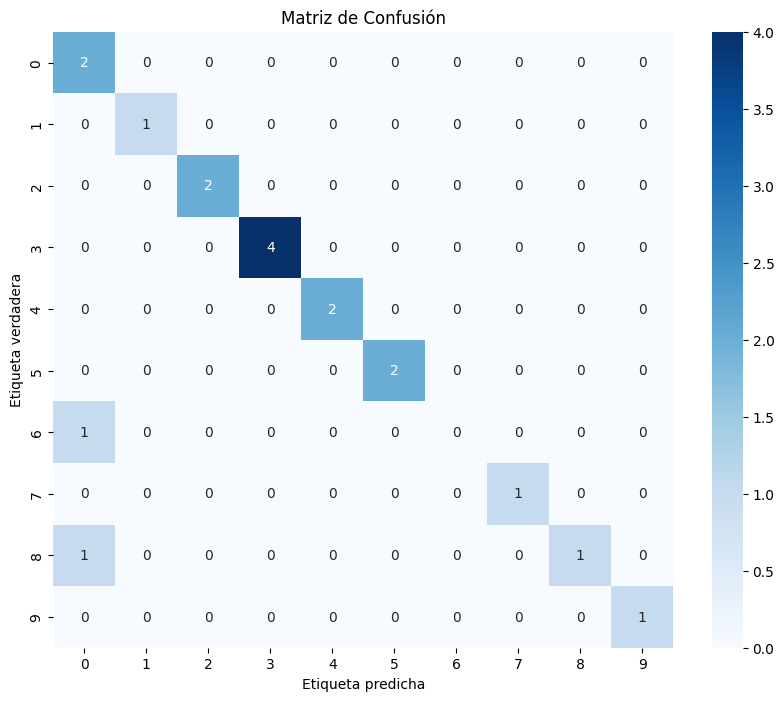

In [60]:
# Evaluar el modelo
print("Reporte:")
print(classification_report(true_labels, predicted_classes_ck))

conf_matrix = confusion_matrix(true_labels, predicted_classes_ck)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Etiqueta predicha')
plt.ylabel('Etiqueta verdadera')
plt.title('Matriz de Confusión')
plt.show()

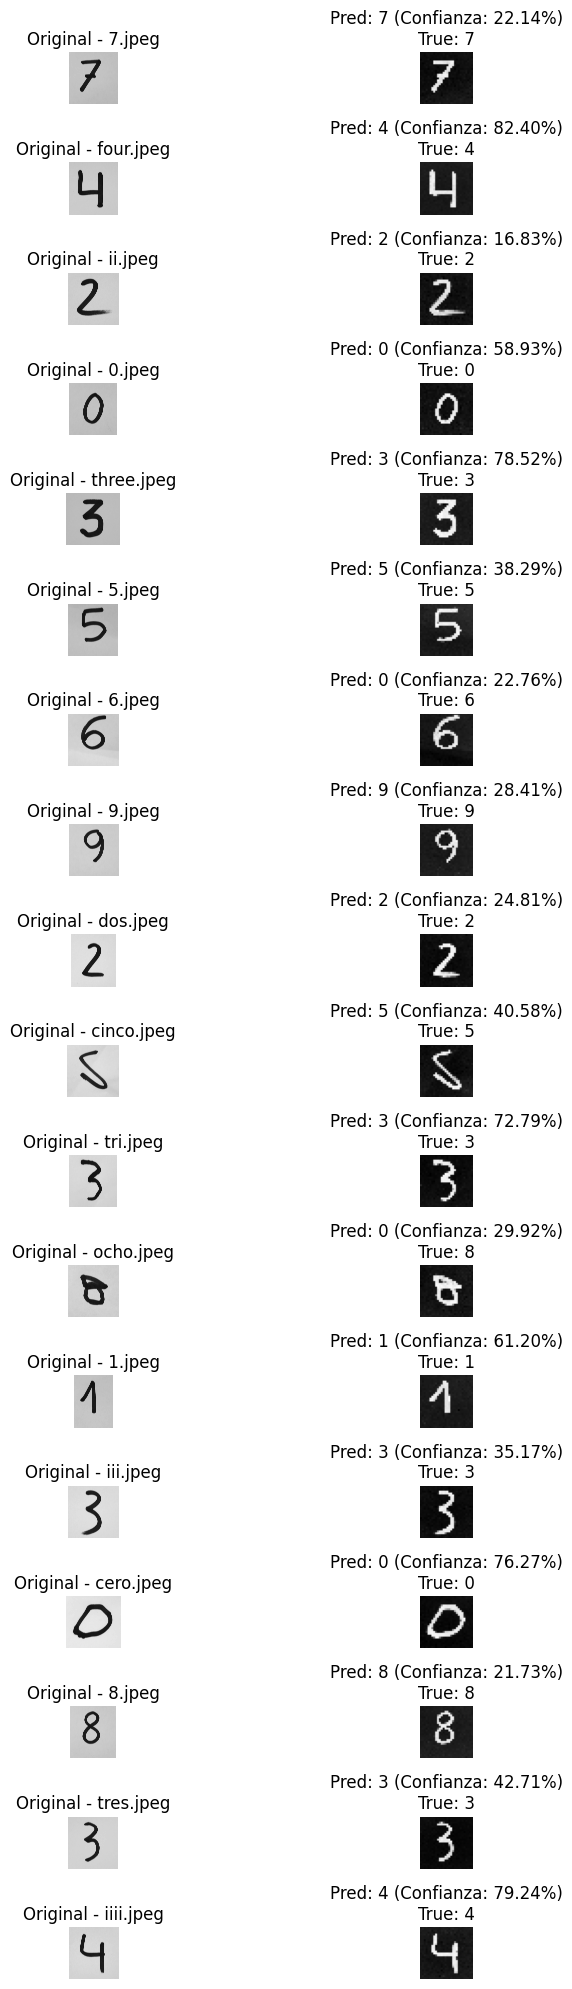

In [61]:
fig, axes = plt.subplots(len(image_files), 2, figsize=(10, 20))
for i, img_filename in enumerate(image_files):
    img_path = os.path.join(folder_path, img_filename)

    original_img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    axes[i, 0].imshow(original_img, cmap='gray')
    axes[i, 0].set_title(f'Original - {img_filename}')
    axes[i, 0].axis('off')

    preprocessed_img = preprocessed_images[i].reshape(28, 28)
    prediction_text = f'Pred: {predicted_classes_ck[i]} (Confianza: {confidence_scores[i]:.2f}%)'
    true_label_text = f'True: {true_labels[i]}'
    axes[i, 1].imshow(preprocessed_img, cmap='gray')
    axes[i, 1].set_title(f'{prediction_text}\n{true_label_text}')
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()

# CONCLUSIONES

1. Carga y Exploración del Dataset

Carga del Dataset: Se utilizó la función mnist.load_data() de Keras para cargar el conjunto de datos MNIST, que contiene 60,000 imágenes de entrenamiento y 10,000 imágenes de prueba.  
Exploración Inicial: Se imprimieron las formas de los datos para confirmar que el dataset se cargó correctamente y se visualizó una muestra de las imágenes para entender mejor los datos con los que íba a trabajar.  
2. Preprocesamiento de los Datos

Normalización: Las imágenes se normalizaron dividiendo los valores de los píxeles por 255 para escalar los valores entre 0 y 1.   
Expansión de Dimensiones: Dado que las capas convolucionales de Keras esperan una entrada con 4 dimensiones (imagenes, altura, anchura, canales), se expandió la dimensión de las imágenes para incluir el canal de color (1 en este caso, ya que las imágenes son en escala de grises).

3. Definición del Modelo


Arquitectura del Modelo: Se diseñó una CNN con 2 capas de convolución, pooling, dropout y densas. Las capas de convolución y pooling son fundamentales para extraer características de las imágenes, mientras que las capas de dropout ayudan a prevenir el sobreajuste, la capa de salida es una softmax que obtiene la predicción para cada una de las clases en este caso 10 ya que intentamos luego poder predecir los números del 0 al 9.      
Compilación del Modelo: Inicialmente, se utilizó el optimizador Adam, que es conocido por su eficacia en muchos problemas de aprendizaje profundo. La pérdida utilizada fue categorical_crossentropy, adecuada para problemas de clasificación multiclase.  
Se implemento la utilización de 3 callbacks early stopping y reduce on plateu basados en la variación de la función de perdida en la validación con una paciencia de 3 y 2 respectivamente y además implemente model checkpoint para poder guardar automáticamente el mejor modelo basado tambien en la función de pérdida de la validación.
5. Búsqueda de Hiperparámetros

Grid Search: Se configuró GridSearchCV para buscar los mejores hiperparámetros, incluyendo el tamaño de batch, el número de épocas ,la tasa de aprendizaje y el dropout. Esto permite encontrar la combinación óptima de hiperparámetros que maximiza el rendimiento del modelo.
Además se utilizaron técnicas de validación cruzada para asegurar que los resultados sean robustos.  
6. Evaluación y Resultados

Evaluación del Modelo: Se evaluó el modelo en el conjunto de datos de prueba para obtener la precisión final. También se generaron y analizaron métricas como la matriz de confusión y el reporte de clasificación para entender mejor el rendimiento del modelo en cada clase.  

7. Predicciones en Imágenes Nuevas

Predicciones y Confianza: Se realizaron predicciones sobre nuevas imágenes y se calculó el porcentaje de confianza para cada predicción.  
Visualización de Resultados: Se mostraron las imágenes originales y preprocesadas junto con las predicciones y sus porcentajes de confianza. Esto ayuda a evaluar visualmente el rendimiento del modelo y su capacidad de generalización a nuevas imágenes.  
  
  

El modelo final alcanzó una alta precisión en el conjunto de datos de prueba, indicando que las técnicas de preprocesamiento y optimización de hiperparámetros fueron en principio efectivas.
La utilización de GridSearchCV permitió identificar la mejor combinación de hiperparámetros, mejorando significativamente el rendimiento del modelo.  
Sin embargo las predicciones en nuevas imágenes mostraron una variabilidad en la confianza, lo que sugiere que el modelo no ha generalizado del todo bien y no está listo para ser utilizado en aplicaciones del mundo real.  

Probablemente para obtener un porcentaje de confianza mas significativo y poder desarrollar un analisis mas eficiente tendría que suministrarle al modelo obtenido mayor cantidad de imágenes nuevas para que pueda clasificarlas y luego evaluar nuevamente los resultados.  
En caso de continuar con variabilidad en los porcentajes obtenidos podría implementar alguna técnica por ejemplo class_weight que priorice los pesos en los números que mas le cuesta clasificar al modelo y volver a entrenarlo.
